# Analyze a Sparse Grid Run

In [1]:
import os
import numpy as np
import xarray as xr
import cftime
import pandas as pd
import glob
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import fates_calibration_library.analysis_functions as analysis
import fates_calibration_library.ilamb_functions as ilamb
import fates_calibration_library.plotting_functions as plotting
import fates_calibration_library.utils as utils

In [19]:
import importlib
import fates_calibration_library.analysis_functions
importlib.reload(fates_calibration_library.analysis_functions)

<module 'fates_calibration_library.analysis_functions' from '/glade/work/afoster/FATES_calibration/scripts/fates_calibration_library/analysis_functions.py'>

In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='02:00:00',                                       # Amount of wall time
    interface='ext')

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44639 instead
  warnings.warn(


In [3]:
cluster.scale(30)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/44639/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/44639/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.173:40441,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/44639/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Set Up

First specify history variables and variables to investigate

In [4]:
fates_vars = ['FATES_FRACTION', 'FATES_GPP', 'FATES_LAI', 'QVEGE',
              'QVEGT', 'EFLX_LH_TOT', 'FSH', 'FSR', 'FSDS', 'FSA',
              'FIRE', 'FLDS', 'FCTR', 'FCEV', 'FGEV', 'BTRANMN',
              'FGR', 'SOILWATER_10CM', 'TWS', 'QRUNOFF', 'SNOWDP',
              'TV', 'TG', 'TSA', 'TBOT']

clm_vars = ['FPSN', 'TLAI', 'QVEGE', 'QVEGT', 'EFLX_LH_TOT', 'FSH',
            'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'FCTR', 'FCEV',
            'FGEV', 'BTRANMN', 'FGR', 'SOILWATER_10CM', 'TWS',
            'QRUNOFF', 'SNOWDP', 'TV', 'TG', 'TSA', 'TBOT']

out_vars = ['GPP', 'LAI', 'EFLX_LH_TOT', 'FSH', 'EF', 'SOILWATER_10CM', 'ASA',
            'FSR', 'FSA', 'FIRE', 'RLNS', 'RN', 'BTRANMN', 'TV']

### Files Needed

In [24]:
# sparse grid clustering file
grid_dir = '/glade/work/afoster/FATES_calibration/surfdata'
grid_file = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sparse_grid = xr.open_dataset(os.path.join(grid_dir, grid_file))

# sparse grid whittaker biomes
whittaker_ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/whittaker/whitkey.nc')

# fetch the sparsegrid landarea - needed for unit conversion
land_area_file = '/glade/work/afoster/FATES_calibration/CLM5PPE/postp/sparsegrid_landarea.nc'
land_area = xr.open_dataset(land_area_file).landarea

# create a global land frac and area grid
land_frac_ds = os.path.join("/glade/derecho/scratch/afoster/archive",
                            "ctsm60SP_bigleaf_fullgrid/lnd/hist",
                            "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")
target_grid = analysis.create_target_grid(land_frac_ds, 'FSR')

# config file with conversion information in it
var_config = '/glade/work/afoster/FATES_calibration/observations/model_conversion.cfg'
var_dict = analysis.get_conversion_dict(var_config)

# ilamb observations
ilamb_config = '/glade/work/afoster/FATES_calibration/observations/ilamb_conversion.cfg'
ilamb_dict = ilamb.get_conf_dict(ilamb_config)
ilamb_obs = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/all_ILAMB_obs.nc')

ValueError: could not convert string to float: 'None'

## Read in Datasets

In [6]:
# default sparse grid run
sparse_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_sparse_vai/lnd/hist'
sparse_ds = analysis.post_process_ds(sparse_dir, fates_vars, whittaker_ds,
                                     2000, 2015, 20)

In [9]:
# global sparse grid run
global_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_full/lnd/hist'
global_ds = analysis.post_process_ds(global_dir, fates_vars, whittaker_ds,
                                      2000, 2015, 20, sparse=False)

## Post-Process Datasets


### Temporal Averaging
First calculate annual and monthly means

In [10]:
# annual means
ann_means_sparse = analysis.get_annual_means(sparse_ds, out_vars, var_dict,
                                             sparse=True).mean(dim='year')

ann_means_glob = analysis.get_annual_means(global_ds, out_vars, var_dict,
                                           sparse=False).mean(dim='year')

In [11]:
# monthly means
month_means_sparse = analysis.get_monthly_means(sparse_ds, out_vars,
                                           var_dict, sparse=True)

month_means_glob = analysis.get_monthly_means(global_ds, out_vars,
                                           var_dict, sparse=False)

### Calculate Month of Max
Calculate the month of the maximum variable

In [12]:
# month of max 
max_month_sparse = analysis.get_month_of_maxes(month_means_sparse, out_vars,
                                               sparse=True)

max_month_glob = analysis.get_month_of_maxes(month_means_glob, out_vars,
                                               sparse=False)

### Remap Sparse Grid

Remap the annual and monthly sparse means to a global grid

In [13]:
# maps from the annual means
sparse_glob = analysis.get_sparse_maps(ann_means_sparse, sparse_grid,
                                     out_vars)

# maps from the monthly maxes
sparse_glob_month_max = analysis.get_sparse_maps(max_month_sparse, sparse_grid,
                                     out_vars)

### Zonal Means
Calculate zonal means (by latitude)

In [20]:
# sparse
zonal_sparse = analysis.get_zonal_means(sparse_glob, out_vars, var_dict,
                                        target_grid.land_area)

# global
zonal_global = analysis.get_zonal_means(ann_means_glob, out_vars,
                                        var_dict, target_grid.land_area)

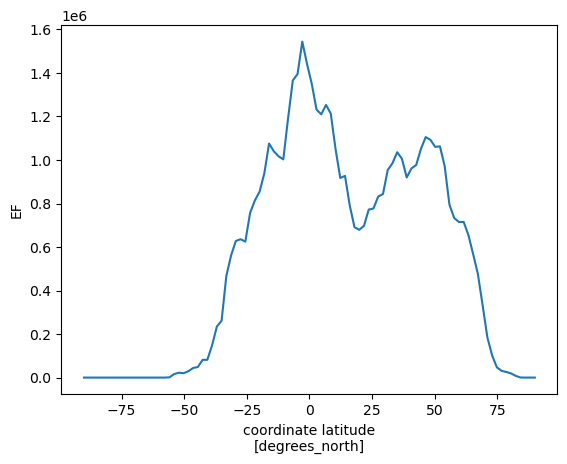

In [23]:
zonal_sparse.EF.plot()

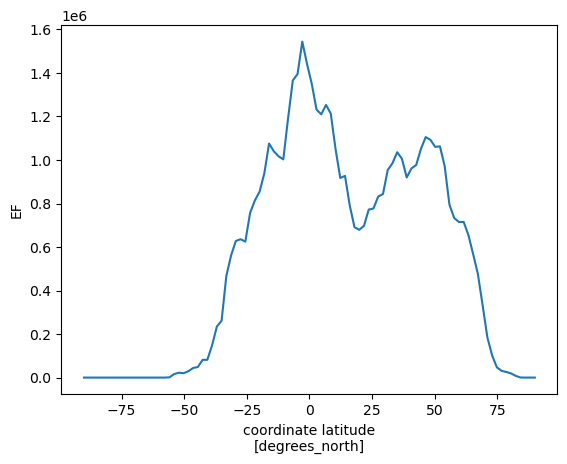

In [17]:
zonal_sparse.EF.plot()

### Climatology
Calculate climatology

In [ ]:
# area means from monthly
sparse_glob_monthly = analysis.get_sparse_area_means(month_means_sparse, 'global',
                                                out_vars, var_dict, land_area,
                                                sparse_ds.biome)

glob_monthly = analysis.get_area_means(month_means_glob, out_vars, var_dict,
                                       target_grid.land_area)

### Calculate Global Annual Values

Area-weighted averages

In [ ]:
# sparse area means
area_means_sparse = analysis.get_sparse_area_means(ann_means_sparse,
                                            'global', out_vars,
                                            var_dict, land_area, sparse_ds.biome)

# global area means 
area_means_glob = analysis.get_area_means(ann_means_glob, out_vars, var_dict,
                                          target_grid.land_area)

## How Well the Does the Sparse Grid Match Global Simulations
### Annual Maps

In [ ]:
var = 'GPP'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'LAI'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'EFLX_LH_TOT'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'FSH'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'EF'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

In [ ]:
var = 'ASA'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

### Zonal Means

### Month of Max

In [ ]:
var = 'GPP'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var],
                                max_month_glob[var], 'Sparse', 'Global', var)

In [ ]:
var = 'LAI'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var], 
                                max_month_glob[var], 'Sparse', 'Global', var)

In [ ]:
var = 'EFLX_LH_TOT'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var],
                                max_month_glob[var], 'Sparse', 'Global', var)

In [ ]:
var = 'FSH'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var],
                                max_month_glob[var], 'Sparse', 'Global', var)

In [ ]:
var = 'EF'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var],
                                max_month_glob[var], 'Sparse', 'Global', var)

In [ ]:
var = 'ASA'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var],
                                max_month_glob[var], 'Sparse', 'Global', var)

### Climatology

In [ ]:
var = 'GPP'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

In [ ]:
var = 'LAI'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

In [ ]:
var = 'EFLX_LH_TOT'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

In [ ]:
var = 'FSH'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

In [ ]:
var = 'EF'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

In [ ]:
var = 'ASA'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

### Global Annual Values

In [ ]:
summary_df = plotting.summarize_differences(area_means_glob, area_means_sparse,
                                            'Global', 'Sparse', var_dict)

In [ ]:
plotting.plot_heatmap(summary_df)

In [ ]:
import importlib
import fates_calibration_library.plotting_functions
import fates_calibration_library.analysis_functions
importlib.reload(fates_calibration_library.analysis_functions)
importlib.reload(fates_calibration_library.plotting_functions)

## Observational Comparisons
### Annual Maps

In [ ]:
var = 'GPP'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_dict[var]['var'], ilamb_dict[var]['models'])
plotting.plot_model_obs_diff(sparse_glob, ilamb_var, target_grid.landfrac, var,
                             var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'ASA'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_dict[var]['var'], ilamb_dict[var]['models'])
plotting.plot_model_obs_diff(sparse_glob, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'EFLX_LH_TOT'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_dict[var]['var'], ilamb_dict[var]['models'])
plotting.plot_model_obs_diff(sparse_glob, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'FSH'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_dict[var]['var'], ilamb_dict[var]['models'])
plotting.plot_model_obs_diff(sparse_glob, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

In [ ]:
var = 'EF'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_dict[var]['var'], ilamb_dict[var]['models'])
plotting.plot_model_obs_diff(sparse_glob, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')